<a href="https://colab.research.google.com/github/SoniaVG/Reinforcement-Learning-IA/blob/main/FrozenLake_DinamicProgram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Frozen Lake**
#Dynamic programming

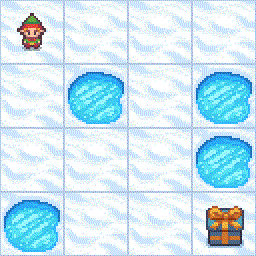

In [3]:
from IPython.display import clear_output

!pip install gymnasium
%matplotlib inline
clear_output()

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym
clear_output()




In [4]:
env = gym.make("FrozenLake-v1",  render_mode="rgb_array", is_slippery=False)

print("Estado inicial:", env.reset())
print("Espacio de acciones: ", env.action_space)
print("Espacio de acciones: ", env.action_space.n)
print("Espacio de observaciones: ", env.observation_space)
print("Reward: ", env.reward_range)


Estado inicial: (0, {'prob': 1})
Espacio de acciones:  Discrete(4)
Espacio de acciones:  4
Espacio de observaciones:  Discrete(16)
Reward:  (0, 1)


# Trayectoria

$\tau = S_0, A_0,R_0, S_1, A_1, R_1,\ldots, S_n,A_n,R_n,$

Trayectoria: [[0, 1, 0.0, False, 4], [4, 2, 0.0, True, 5]]


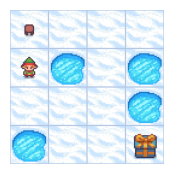

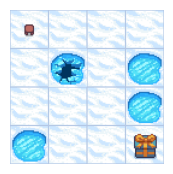

In [5]:
# Politica aleatoria
# Guardar la trayectoria

done = False
state = env.reset()[0]
trayectoria = []


while not done:
  action =  env.action_space.sample()
  next_state, reward, done, info,_ = env.step(action)
  #print("observation",next_state, "; reward", reward, "; done?",done)
  trayectoria.append([state, action, reward, done, next_state])
  state = next_state
  plt.figure(figsize = (20,2))
  plt.axis("off")
  plt.imshow(env.render())


print("Trayectoria:", trayectoria)


In [6]:
def simulate_step(estado, action):

  if action == 0:
    if estado not in  [0,4,8,12]:
      next_state = estado - 1
    else:
      next_state = estado

  elif action == 1:
    if estado not in  [12,13,14,15]:
      next_state = estado + 4
    else:
      next_state = estado

  elif action == 2:
    if estado not in  [3,7,11,15]:
      next_state = estado + 1
    else:
      next_state = estado

  elif action == 3:
    if estado not in  [0,1,2,3]:
      next_state = estado - 4
    else:
      next_state = estado
  else:
    raise ValueError("Accion no valida")

  if next_state == 15:
    return next_state, 1
  else:
    return next_state, 0

simulate_step(13, 1)

(13, 0)

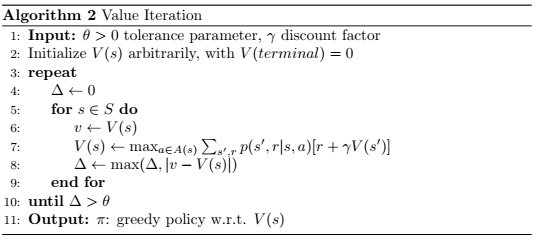

In [34]:
# La configuración del estado es 0-15
def value_iteration(policy_probs, state_values , theta=1e-6, gamma =0.99 ):
  delta = float("inf")

  while delta > theta:
    delta = 0

    for estado in range(16): #para este estado ¿cuál es la acción más probable?
      old_value = state_values[estado]
      actions_probs =   None
      max_qsa = float("-inf")

      for action in range(4):
        next_state, reward = simulate_step(estado, action) #simular que da un paso observation, reward, done, info,_
        qsa = reward + gamma * state_values[next_state]

        if qsa > max_qsa:
          max_qsa = qsa
          actions_probs= np.zeros(4)
          actions_probs[action] = 1. #accion más probable

      state_values[estado] = max_qsa
      policy_probs[estado] = actions_probs

      delta = max(delta, abs(max_qsa - old_value))

In [35]:
policy_probs =np.zeros((16,4))
state_values = np.zeros(16)
value_iteration(policy_probs, state_values , theta=1e-6, gamma =0.99 )

In [36]:
state_values

array([95.09890636, 96.05950237, 97.02980137, 98.00990137, 96.05950237,
       97.02980137, 98.00990137, 98.99990137, 97.02980137, 98.00990137,
       98.99990137, 99.99990137, 98.00990137, 98.99990137, 99.99990137,
       99.99990137])

# Mejora de politica
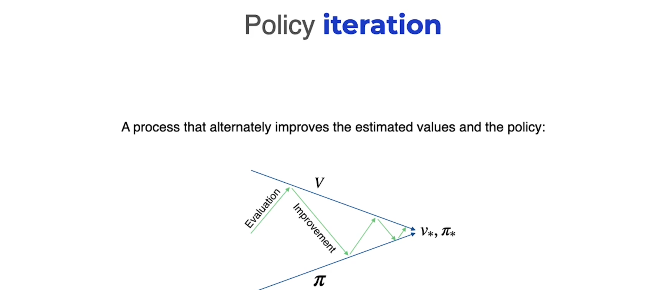

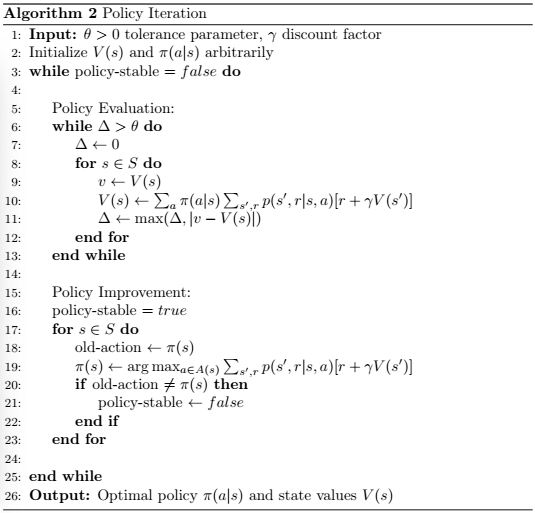

In [19]:
def  policy_evaluetion(policy_probs, state_values , theta=1e-6, gamma =0.99):
  delta = float("inf")

  while delta > theta:
    delta = 0

    for estado in range(16): #para este estado ¿cuál es la acción más probable?
      old_value = state_values[estado]
      new_value = 0.0
      action_probabilities = policy_probs[estado]


      for action, prob in enumerate(action_probabilities):
        next_state, reward = simulate_step(estado, action) #simular que da un paso observation, reward, done, info,_
        new_value += prob * (reward + gamma * state_values[next_state])

      state_values[estado] = new_value

      delta = max(delta, abs(old_value-new_value))

In [20]:
def policy_improvement(policy_probs, state_values , gamma =0.99 ):
  policy_stable = True

  for estado in range(16):
      old_action = policy_probs[estado].argmax()

      new_action = None
      max_qsa = float("-inf")

      for action in range(4):
        next_state, reward= simulate_step(estado, action)#simular que da un paso observation, reward, done, info,_
        qsa = reward + gamma * state_values[next_state]

        if qsa > max_qsa:
          new_action = action
          max_qsa = qsa

      action_probs = np.zeros(4)
      action_probs[new_action]= 1.
      policy_probs[estado] = action_probs

      if new_action != old_action:
        policy_stable = False

  return policy_stable

In [24]:
policy_probs =np.full((16,4),0.25)
state_values = np.zeros(16)
env.reset()

def policy_iteration(policy_probs, state_values , theta=1e-5, gamma =0.89):
  policy_stable = False

  while not policy_stable:
    policy_evaluetion(policy_probs, state_values , theta, gamma  )
    policy_stable = policy_improvement(policy_probs, state_values , gamma  )


policy_iteration(policy_probs, state_values)

[1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1]
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [2 2 2 1]]


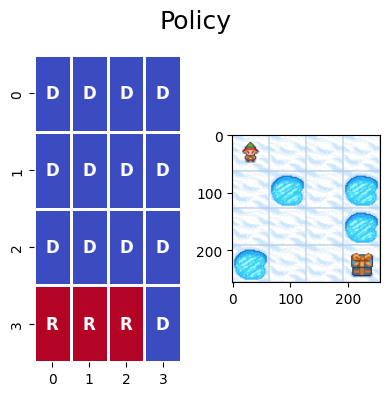

In [25]:

def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'L', 1: 'D', 2: 'R', 3: 'U'}

    fig, axes = plt.subplots(1, 2, figsize=(4, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    print(max_prob_actions)
    probs_copy = max_prob_actions.copy().astype(object)

    for key in action_meanings:
      posiciones =  np.where(np.array(probs_copy)==key)[0]
      for i in posiciones:
        probs_copy[i] = action_meanings[key]

    max_prob_actions = max_prob_actions.reshape((4, 4))
    print(max_prob_actions)
    probs_copy = probs_copy.reshape((4, 4))
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])

    axes[1].imshow(frame)
    #axes[0].axis('off')
    #axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()


plot_policy(policy_probs, env.render())

# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

#------------3------
#------------|------
#------0-<--- --->-2
#----- ------|------
#------------1------

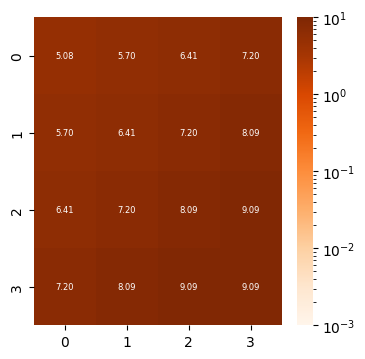

<Figure size 600x600 with 0 Axes>

In [33]:
import matplotlib.colors as colors

def plot_values(state_values):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(state_values, mask=state_values <5,cmap='Oranges', norm=colors.LogNorm(vmin=0.001, vmax=10), vmin=0.001, vmax=0.5,
            annot=True, fmt='.2f', annot_kws={"size": 6}, xticklabels=[], yticklabels=[], ax=ax)
    sns.heatmap(state_values, mask=state_values>=0.5,
            cmap='Blues', norm=colors.Normalize(vmin=0, vmax=1), vmin=0.5, vmax=1, cbar=False,
            annot=True, fmt='.2f', annot_kws={"size": 6},ax=ax)
    plt.figure(figsize = (6,6))
    plt.show()



reshape_state_values = state_values.reshape((4,4))
plot_values(reshape_state_values)